# Data Structure Overview

## The `my_spectra` Array

The `my_spectra` array contains all the spectra loaded from the file.

### Array Structure
Each element in the array follows this format:
```
[mzs, intensities, coordinates]
```

### Component Descriptions

- **`mzs`**: An array of recorded m/z values for that pixel
- **`intensities`**: An array of recorded intensities corresponding to the m/z values for that pixel  
- **`coordinates`**: A tuple in the form `(x, y, z)` where `z=1` for all pixels

### Key Points
- Each spectrum corresponds to a specific spatial location
- The x,y coordinates allow mapping spectra to their physical positions

In [17]:
from pyimzml.ImzMLParser import ImzMLParser
import numpy as np
import random
import math
import matplotlib.pyplot as plt



p = ImzMLParser('../Data/LPS/LPS1.imzml')
my_spectra = []
for idx, (x,y,z) in enumerate(p.coordinates):
    mzs, intensities = p.getspectrum(idx)
    my_spectra.append([mzs, intensities, (x, y, z)])

print(f"Total spectra loaded: {len(my_spectra)}")

    

Total spectra loaded: 1640


/home/vmuser/anaconda3/lib/python3.12/site-packages/pyimzml/ontology/ontology.py:80: UserWarning: Unrecognized accession in <cvParam>:  (name: "").
  warn('Unrecognized accession in <cvParam>: %s (name: "%s").' % (accession, raw_name))
/home/vmuser/anaconda3/lib/python3.12/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession IMS:1000042 found with incorrect name "max count of pixel x". Updating name to "max count of pixels x".
  warn(
/home/vmuser/anaconda3/lib/python3.12/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession IMS:1000043 found with incorrect name "max count of pixel y". Updating name to "max count of pixels y".
  warn(
/home/vmuser/anaconda3/lib/python3.12/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession IMS:1000046 found with incorrect name "pixel size x". Updating name to "pixel size (x)".
  warn(


In [19]:
max_mz = -float('inf')
min_mz = float('inf')
for spectrum in my_spectra:
    max_mz = math.ceil(max(max(spectrum[0]),max_mz))
    min_mz = math.floor(min(min(spectrum[0]),min_mz))
print(f'Range of mz values:',(min_mz,max_mz))


# Assuming `my_spectra` contains tuples of (mzs, intensities, (x, y)) where (x, y) are the coordinates of the spectrum.

# Define the range of x and y coordinates
x_coords = sorted(set(coord[0] for _, _, coord in my_spectra))
y_coords = sorted(set(coord[1] for _, _, coord in my_spectra))

# Create mappings from coordinates to indices
x_to_index = {x: i for i, x in enumerate(x_coords)}
y_to_index = {y: i for i, y in enumerate(y_coords)}

# Initialize the 3D array: k x p x m
common_mzs = np.arange(min_mz, max_mz, 0.02)
binned = np.zeros((len(y_coords), len(x_coords),len(common_mzs)), dtype=np.float32)

# Populate the 3D array
for mzs, intensities, (x, y,_) in my_spectra:
    x_idx = x_to_index[x]
    y_idx = y_to_index[y]
    indices = np.digitize(mzs, common_mzs) - 1
    for k, val in zip(indices, intensities):
        if 0 <= k < binned.shape[2]:
            binned[y_idx, x_idx, k] += val

# Normalize the intensities along the m-axis (summing over k)
tic = binned.sum(axis=2, keepdims=True)
tic[tic == 0] = 1

X = binned / tic

X_min = X.min(axis=1, keepdims=True)
X_max = X.max(axis=1, keepdims=True)
X = (X - X_min) / (X_max - X_min + 1e-6)

# Convert to float16 AFTER normalization (values are now 0-1 range)
X = X.astype(np.float16)

Range of mz values: (150, 2000)


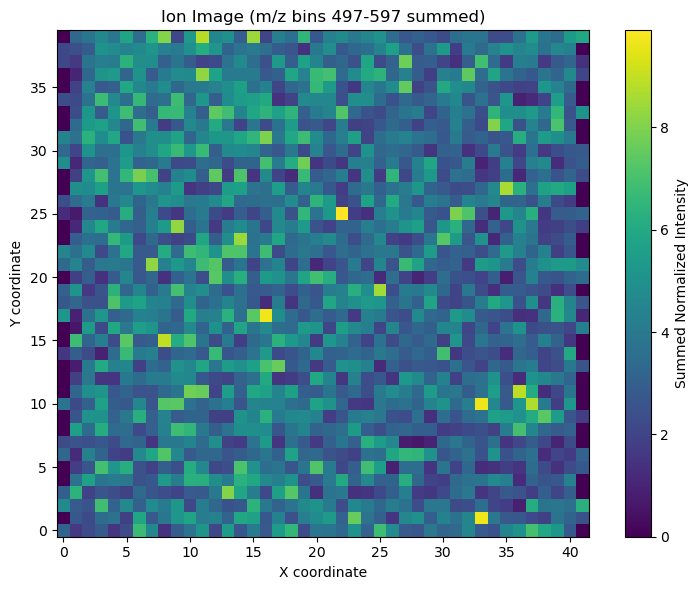

In [23]:
plt.figure(figsize=(8, 6))
plt.imshow(X[:, :, 497:598].sum(axis=2), cmap='viridis', origin='lower')
plt.colorbar(label='Summed Normalized Intensity')
plt.title('Ion Image (m/z bins 497-597 summed)')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.tight_layout()
plt.show()

**1. The above cell show that there are only 2 relevant coordinates (x,y) since z=1 for each spectrum**

**From this we can conclude that each spectrum can be plotted on a cartesian plane**

**2. We can see that we always have the same number of intensities as m/z ratios**

**With this array, we can plot the 2D graph of intensities vs m/z for a single pixel point**



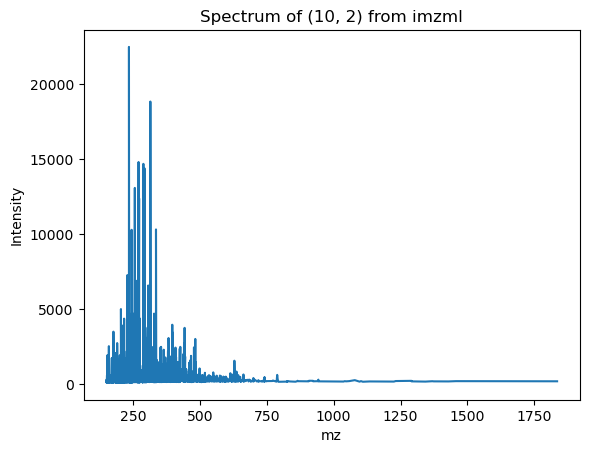

In [ ]:
rand = random.randint(0,len(my_spectra)-1)
spectrumy = my_spectra[rand]
# spectrumx = processed_spectra[rand]
# spectrumx = my_spectra[2]
plt.plot(spectrumy[0],spectrumy[1])
# plt.plot(spectrumx[0],spectrumx[1] ,alpha=0.7)
title = "Spectrum of " + str(spectrumy[2][:2]) + " from imzml"
plt.title(title)
plt.xlabel("mz")
plt.ylabel("Intensity")
plt.show()

# print(spectrumx[0][:5])
# print(spectrumx[1][:5])


42 41
Points found 1636


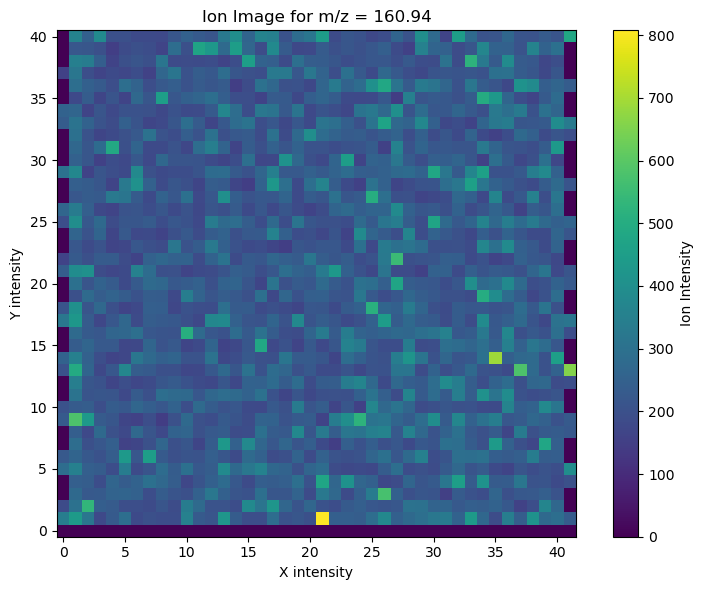

In [14]:

# Choose the m/z you want to plot  and tolerance
target_mz = 160.94
tolerance = 1

# Get image dimensions
all_coords = [coord for _, _, coord in my_spectra]
xs, ys, _ = zip(*all_coords)
width = max(xs) + 1
height = max(ys) + 1
print(width,height)



# Create empty image
ion_image = np.zeros((height, width))

# Fill in the ion image with intensities for target m/z
times = 0 
for mzs, intensities, (x, y, _) in my_spectra:
    # Get mask of indices where mz is within target window
    mz_mask = (mzs >= target_mz - tolerance) & (mzs <= target_mz + tolerance)
    if np.any(mz_mask):
        times+=1
        ion_intensity = np.mean(intensities[mz_mask])
        ion_image[y, x] = ion_intensity
print(f"Points found", times)

# Plot the ion image
plt.figure(figsize=(8, 6))
plt.imshow(ion_image, cmap='viridis', origin='lower')
plt.colorbar(label='Ion Intensity')
plt.title(f"Ion Image for m/z = {target_mz}")
plt.xlabel("X intensity")
plt.ylabel("Y intensity")
plt.tight_layout()
plt.show()